# Transformer Autoencoder Validation

## Load SILVA Dataset

In [1]:
from Bio import SeqIO
import numpy as np
from tqdm.notebook import tqdm
s = np.array([record for record in tqdm(SeqIO.parse('silva.fasta', "fasta"))], dtype=object)

0it [00:00, ?it/s]

In [2]:
import multiprocessing as mp
from tqdm.notebook import tqdm
def fn(i):
    return np.array(list(str(i.seq)[:300]))
with mp.Pool() as p:
    string_seqs = np.array(list(tqdm(p.imap(fn, s, chunksize=100), total=s.shape[0])))

  0%|          | 0/227331 [00:00<?, ?it/s]

In [3]:
BASES = ['A', 'U', 'G', 'C']
def fn(i):
    enc_seq = np.empty((300, 5), dtype=np.intc)
    for bp in range(string_seqs.shape[1]):
        idx = BASES.index(i[bp]) if i[bp] in BASES else 4
        enc_seq[bp] = [1 if j == idx else 0 for j in range(5)]
    return enc_seq
with mp.Pool() as p:
    seqs = np.asarray(list(tqdm(p.imap(fn, string_seqs, chunksize=100), total=string_seqs.shape[0])))

  0%|          | 0/227331 [00:00<?, ?it/s]

In [4]:
desc = np.array([i.description.split(' ')[1] for i in s])
num_items = np.vectorize(lambda i: len(i.split(';')))(desc)
parsable = num_items == 7
raw_tax = desc[parsable]
tax = []
for i in raw_tax:
    tax.append(i.split(';'))
tax = np.array(tax)
seqs = seqs[parsable]

## Pretrain on SILVA Dataset

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [59]:
import tensorflow as tf
from tensorflow.keras import layers

mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    inputs = layers.Input((300, 5))
    res = layers.Reshape((100, 5 * 3))(inputs)
    trans = TransformerBlock(5 * 3, 8, 300)(res)
    res2 = layers.Flatten()(trans)
    bottleneck = layers.Dense(2)(res2)
    encoder = tf.keras.Model(inputs=inputs, outputs=bottleneck)

    exp = layers.Dense(100 * 5 * 3)(bottleneck)
    res3 = layers.Reshape((100, 5 * 3))(exp)
    trans2 = TransformerBlock(5 * 3, 8, 300)(res3)
    res4 = layers.Reshape((5, 300))(trans2)
    den = layers.Dense(300, activation='softmax')(res4)
    out = layers.Reshape((300, 5))(den)

    silva_ae = tf.keras.Model(inputs=inputs, outputs=out)

    silva_ae.compile(optimizer='adam',
                    loss=tf.keras.losses.CategoricalCrossentropy(),
                    metrics=[tf.keras.metrics.MeanAbsoluteError()])
silva_ae.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 300, 5)]          0         
                                                                 
 reshape_41 (Reshape)        (None, 100, 15)           0         
                                                                 
 transformer_block_23 (Trans  (None, 100, 15)          16950     
 formerBlock)                                                    
                                                                 
 flatten_7 (Flatten)         (None, 1500)              0         
                                                                 
 dense_85 (Dense)            (None, 2)                 3002      
                                                                 
 dense_86 (Dense)            (None, 1500)              4500      
                                                          

In [60]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(seqs, seqs, test_size=.1)

silva_ae.fit(x_train,
            y_train,
            validation_data=(x_val, y_val),
            callbacks=[tf.keras.callbacks.EarlyStopping(patience=1, monitor='val_loss'),
                      tf.keras.callbacks.ModelCheckpoint(filepath='Models/silva_ae.ckpt',
                                                        save_best_only=True,
                                                        save_weights_only=True)],
            batch_size=100,
            epochs=100)

Epoch 1/100


2022-06-09 15:07:27.518360: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_492405"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:657"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRO

INFO:tensorflow:batch_all_reduce: 38 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 38 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 38 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 38 all-reduces with algorithm = nccl, num_packs = 1


1625/1625 [==============================] - ETA: 0s - loss: 0.6314 - mean_absolute_error: 0.1985

2022-06-09 15:07:51.386611: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_507514"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:687"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRO

1625/1625 [==============================] - 27s 13ms/step - loss: 0.6314 - mean_absolute_error: 0.1985 - val_loss: 0.5088 - val_mean_absolute_error: 0.1981
Epoch 2/100
1625/1625 [==============================] - 19s 12ms/step - loss: 0.4968 - mean_absolute_error: 0.1980 - val_loss: 0.4612 - val_mean_absolute_error: 0.1979
Epoch 3/100
1625/1625 [==============================] - 18s 11ms/step - loss: 0.4636 - mean_absolute_error: 0.1979 - val_loss: 0.4387 - val_mean_absolute_error: 0.1978
Epoch 4/100
1625/1625 [==============================] - 18s 11ms/step - loss: 0.4456 - mean_absolute_error: 0.1978 - val_loss: 0.4196 - val_mean_absolute_error: 0.1978
Epoch 5/100
1625/1625 [==============================] - 18s 11ms/step - loss: 0.4342 - mean_absolute_error: 0.1978 - val_loss: 0.4164 - val_mean_absolute_error: 0.1978
Epoch 6/100
1625/1625 [==============================] - 18s 11ms/step - loss: 0.4267 - mean_absolute_error: 0.1978 - val_loss: 0.4132 - val_mean_absolute_error: 0.197

In [30]:
silva_ae.trainable = False

In [35]:
silva_ae.save('Models/silva_ae')

INFO:tensorflow:Assets written to: Models/silva_ae/assets


INFO:tensorflow:Assets written to: Models/silva_ae/assets


In [38]:
silva_ae = tf.keras.models.load_model('Models/silva_ae')

In [40]:
seq_reps = encoder.predict(seqs, verbose=1)

5642/5642 [==============================] - 9s 2ms/step


### Reconstruction Accuracy

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

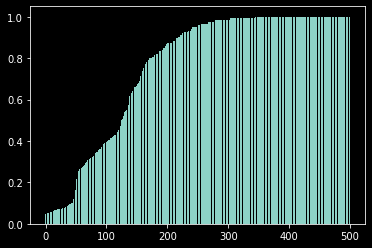

In [38]:
rng = np.random.default_rng()
sample_ind = rng.integers(0, seqs.shape[0], 500)
sample = seqs[sample_ind]
pred = tf.math.argmax(silva_ae(sample), axis=2)
init = np.argmax(sample, axis=2)

import matplotlib.pyplot as plt
plt.style.use('dark_background')

diffs = pred - init
direct_comparison_scores = np.abs(diffs).sum(axis=1)
direct_comparison_scores.sort()
plt.bar(np.arange(direct_comparison_scores.shape[0]), direct_comparison_scores)
plt.show()

codes = BASES + ['N']
def to_str(s):
    return ''.join(codes[i] for i in s)
init_dec = []
for i in tqdm(init):
    init_dec.append(to_str(i))
pred_dec = []
for i in tqdm(pred):
    pred_dec.append(to_str(i))
init_dec, pred_dec = np.array(init_dec), np.array(pred_dec)

from skbio.alignment import local_pairwise_align_ssw
from skbio.sequence import RNA
def score(a, b):
    return local_pairwise_align_ssw(RNA(a), RNA(b))[1]
aln_comparison_scores = []
for i in range(len(init_dec)):
    aln_comparison_scores.append(score(init_dec[i], pred_dec[i]) / 600)
aln_comparison_scores = np.array(aln_comparison_scores)
aln_comparison_scores.sort()
plt.bar(np.arange(len(aln_comparison_scores)), aln_comparison_scores)
plt.show()

In [39]:
aln_comparison_scores.mean()

0.7571833333333334

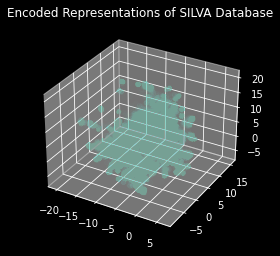

In [55]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

x1, y1, z1 = zip(*(seq_reps))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, y1, z1, alpha=.02, marker='o')
ax.set_title("Encoded Representations of SILVA Database")
plt.show()

In [469]:
archaea = seq_reps[tax[:, 0] == 'Archaea'][:500]
bacteria = seq_reps[tax[:, 0] == 'Bacteria'][:500]
eukaryota = seq_reps[tax[:, 0] == 'Eukaryota'][:500]

NameError: name 'seq_reps' is not defined

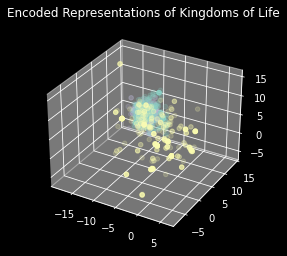

In [71]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

x1, y1, z1 = zip(*archaea)
x2, y2, z2 = zip(*bacteria)
x3, y3, z3 = zip(*eukaryota)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, y1, z1, alpha=.2, marker='o')
ax.scatter(x2, y2, z2, alpha=.2, marker='o')
ax.scatter(x3, y3, z3, alpha=.2, marker='o')
ax.set_title("Encoded Representations of Kingdoms of Life")
plt.show()

### 2D Compressor

In [74]:
import tensorflow as tf
from tensorflow.keras import layers
inputs = layers.Input((3,))
bn = layers.Dense(2)(inputs)
l2_enc = tf.keras.Model(inputs=inputs, outputs=bn)
out = layers.Dense(3)(bn)
l2_ae = tf.keras.Model(inputs=inputs, outputs=out)
l2_ae.compile(optimizer='adam',
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
l2_ae.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_9 (Dense)             (None, 2)                 8         
                                                                 
 dense_10 (Dense)            (None, 3)                 9         
                                                                 
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [75]:
l2_ae.fit(seq_reps, seq_reps, validation_split=.1,
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=1, monitor='val_loss')],
            batch_size=100,
            epochs=100)

Epoch 1/100
1625/1625 [==============================] - 8s 5ms/step - loss: 30.7199 - mean_absolute_error: 3.9742 - val_loss: 11.7482 - val_mean_absolute_error: 2.7792
Epoch 2/100
1625/1625 [==============================] - 7s 5ms/step - loss: 7.3233 - mean_absolute_error: 1.8989 - val_loss: 6.0671 - val_mean_absolute_error: 1.8255
Epoch 3/100
1625/1625 [==============================] - 7s 5ms/step - loss: 5.6310 - mean_absolute_error: 1.6873 - val_loss: 4.1172 - val_mean_absolute_error: 1.4537
Epoch 4/100
1625/1625 [==============================] - 7s 5ms/step - loss: 5.2306 - mean_absolute_error: 1.7148 - val_loss: 4.2100 - val_mean_absolute_error: 1.5593


In [76]:
l2_ae.save_weights('Models/silva_l2_weights.h5')

In [77]:
seqs_2d = l2_enc(seq_reps)

In [472]:
archaea = seqs_2d[tax[:, 0] == 'Archaea']
archaea_samp = archaea.numpy()[rng.integers(0, archaea.shape[0], 500)]
bacteria = seqs_2d[tax[:, 0] == 'Bacteria']
bacteria_samp = bacteria.numpy()[rng.integers(0, bacteria.shape[0], 500)]
eukaryota = seqs_2d[tax[:, 0] == 'Eukaryota']
eukaryota_samp = eukaryota.numpy()[rng.integers(0, eukaryota.shape[0], 500)]

NameError: name 'seqs_2d' is not defined

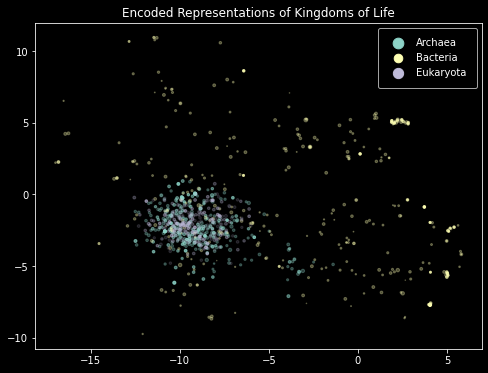

In [144]:
import matplotlib.pyplot as plt

x1, y1 = zip(*archaea_samp)
x2, y2 = zip(*bacteria_samp)
x3, y3= zip(*eukaryota_samp)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.scatter(x1, y1, z1, alpha=.3, marker='o')
ax.scatter(x2, y2, z2, alpha=.3, marker='o')
ax.scatter(x3, y3, z3, alpha=.15, marker='o')
ax.set_title("Encoded Representations of Kingdoms of Life")
leg = plt.legend(['Archaea', 
                  'Bacteria',
                  'Eukaryota'],
                markerscale=4,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.show()

### PCoA

In [477]:
archaea = seqs[tax[:, 0] == 'Archaea'].argmax(axis=-1)
bacteria = seqs[tax[:, 0] == 'Bacteria'].argmax(axis=-1)
eukaryota = seqs[tax[:, 0] == 'Eukaryota'].argmax(axis=-1)
archaea_samp = archaea[rng.integers(0, archaea.shape[0], 500)]
bacteria_samp = bacteria[rng.integers(0, bacteria.shape[0], 500)]
eukaryota_samp = eukaryota[rng.integers(0, eukaryota.shape[0], 500)]

In [478]:
def pcoa(seqs):
    from scipy.spatial import distance_matrix
    raw_dm = distance_matrix(seqs, seqs)
    from skbio.stats.ordination import pcoa
    pcoa_results = pcoa(raw_dm)
    return pcoa_results

/Users/NikhilKalidasu/miniforge3/envs/biotech/lib/python3.9/site-packages/skbio/stats/ordination/_ordination_results.py:285: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


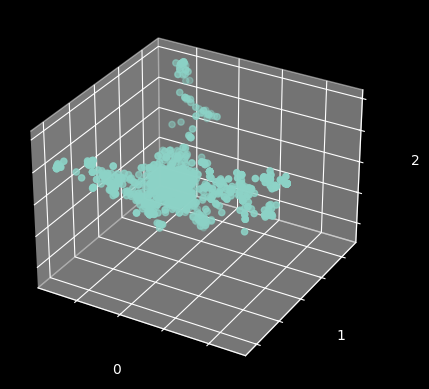

In [479]:
combined = np.concatenate([archaea_samp, bacteria_samp, eukaryota_samp])
pcoa_results = pcoa(combined)
pcoa_results

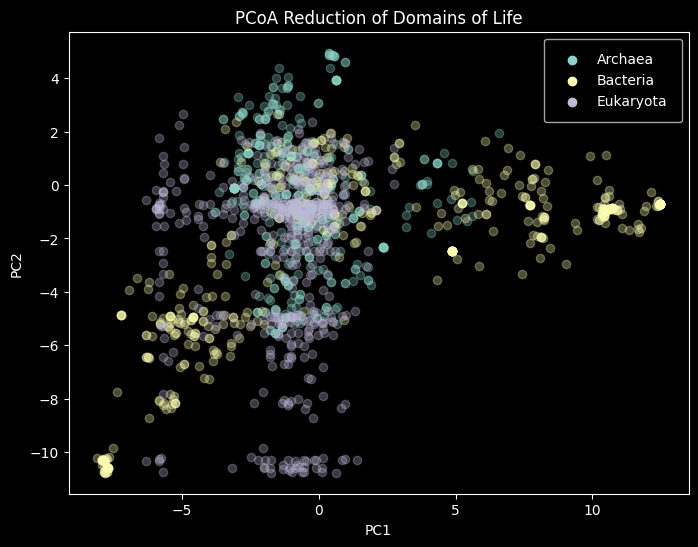

In [481]:
a_red = pcoa_results.samples.iloc[:500]
b_red = pcoa_results.samples.iloc[500:1000]
c_red = pcoa_results.samples.iloc[1000:]
f = plt.figure(figsize=(8, 6))
plt.scatter(a_red['PC1'], a_red['PC2'], alpha=.3)
plt.scatter(b_red['PC1'], b_red['PC2'], alpha=.3)
plt.scatter(c_red['PC1'], b_red['PC2'], alpha=.3)
leg = plt.legend(['Archaea', 
                  'Bacteria',
                  'Eukaryota'],
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title('PCoA Reduction of Domains of Life')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### Statistical Test

In [163]:
rng = np.random.default_rng()
cont = np.concatenate([archaea_samp, eukaryota_samp])
rng.shuffle(cont)

In [164]:
from scipy.spatial import distance_matrix
exp_dist = distance_matrix(eukaryota_samp, bacteria_samp)
cont_dist = distance_matrix(cont[:500], cont[500:])

In [165]:
exp_mindist = exp_dist.min(axis=1)
cont_mindist = cont_dist.min(axis=1)

In [166]:
from scipy.stats import ttest_ind
t, p = ttest_ind(exp_mindist, cont_mindist, equal_var=False)
t, p

(20.712833012835038, 1.5111665004659898e-79)

### Encodings vs Sequence Alignment

In [216]:
samp_ind = rng.integers(0, seq_reps.shape[0], 1000)
sampa, sampb = samp_ind[:500], samp_ind[500:]
rep_sampa, rep_sampb = seq_reps[sampa], seq_reps[sampb]
seq_sampa, seq_sampb = seqs[sampa].argmax(axis=-1), seqs[sampb].argmax(axis=-1)

In [217]:
def decode(sample):
    str_seq_samp = []
    for i in sample:
        str_seq_samp.append(to_str(i))
    return np.asarray(str_seq_samp)
seq_sampa = decode(seq_sampa)
seq_sampb = decode(seq_sampb)

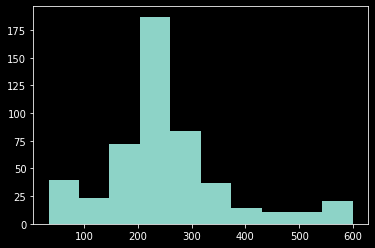

In [218]:
from skbio.alignment import local_pairwise_align_ssw
from skbio.sequence import RNA
def score(a, b):
    return local_pairwise_align_ssw(RNA(a), RNA(b))[1]
aln_scores = np.empty((len(seq_sampa),))
for i in range(len(seq_sampa)):
    aln_scores[i] = score(seq_sampa[i], seq_sampb[i])
plt.hist(aln_scores)
plt.show()

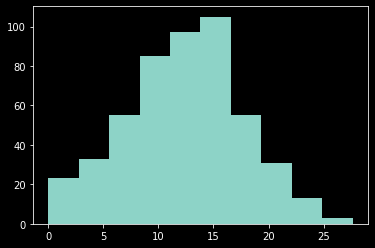

In [219]:
from scipy.spatial.distance import euclidean
euclidean_dists = np.empty((len(rep_sampa),))
for i in range(len(rep_sampa)):
    euclidean_dists[i] = euclidean(rep_sampa[i], rep_sampb[i])
plt.hist(euclidean_dists)
plt.show()

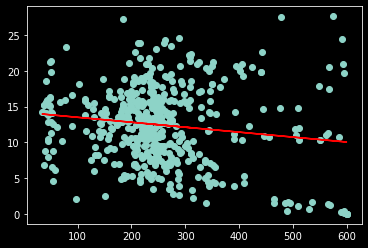

In [220]:
plt.scatter(aln_scores, euclidean_dists)
a, b = np.polyfit(aln_scores, euclidean_dists, 1)
plt.plot(aln_scores, a * aln_scores + b, 'r')
plt.show()

## SILVA AE + Kingdom-Level Classifier

### PCoA

In [464]:
def pcoa(seqs):
    from scipy.spatial import distance_matrix
    raw_dm = distance_matrix(seqs, seqs)
    from skbio.stats.ordination import pcoa
    pcoa_results = pcoa(raw_dm)
    return pcoa_results

In [465]:
combined = np.concatenate([seqs[tax[:, 0] == 'Archaea'][a_s].argmax(axis=-1),
                           seqs[tax[:, 0] == 'Bacteria'][b_s].argmax(axis=-1),
                          seqs[tax[:, 0] == 'Eukaryota'][e_s].argmax(axis=-1)])
pcoa_results = pcoa(combined)
pcoa_results

NameError: name 'a_s' is not defined

In [466]:
a_red = pcoa_results.samples.iloc[:1000]
b_red = pcoa_results.samples.iloc[1000:2000]
c_red = pcoa_results.samples.iloc[2000:]
f = plt.figure(figsize=(8, 6))
plt.scatter(a_red['PC1'], a_red['PC2'], alpha=.3)
plt.scatter(b_red['PC1'], b_red['PC2'], alpha=.3)
plt.scatter(c_red['PC1'], b_red['PC2'], alpha=.3)
leg = plt.legend(['Archaea', 
                  'Bacteria',
                  'Eukaryota'],
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title('PCoA Reduction of Domains of Life')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

NameError: name 'pcoa_results' is not defined

### Model

In [40]:
import tensorflow as tf
from tensorflow.keras import layers

inputs = layers.Input((3,))
# bn = layers.Dense(3)(bottleneck)
bn = layers.Dense(3)(inputs)
rep_enc = tf.keras.Model(inputs=inputs, outputs=bn)
out2 = layers.Dense(3, activation='softmax')(bn)

silva_classifier = tf.keras.Model(inputs=inputs, outputs=out2)
silva_classifier.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
silva_classifier.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_13 (Dense)            (None, 3)                 12        
                                                                 
 dense_14 (Dense)            (None, 3)                 12        
                                                                 
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________


In [45]:
y = np.zeros((tax.shape[0], 3))
y[tax[:, 0] == 'Archaea', 0] = 1
y[tax[:, 0] == 'Bacteria', 1] = 1
y[tax[:, 0] == 'Eukaryota', 2] = 1
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(seq_reps, y, test_size=.1)

silva_classifier.fit(x_train,
            y_train,
            validation_data=(x_val, y_val),
            callbacks=[tf.keras.callbacks.EarlyStopping(patience=1, monitor='val_loss'),
                      tf.keras.callbacks.ModelCheckpoint(filepath='Models/silva_ae.ckpt',
                                                        save_best_only=True,
                                                        save_weights_only=True)],
            batch_size=100,
            epochs=100)

Epoch 1/100
1625/1625 [==============================] - 11s 7ms/step - loss: 0.0046 - mean_absolute_error: 0.0013 - val_loss: 0.0015 - val_mean_absolute_error: 8.0354e-04
Epoch 2/100
1625/1625 [==============================] - 11s 7ms/step - loss: 0.0016 - mean_absolute_error: 5.5435e-04 - val_loss: 0.0012 - val_mean_absolute_error: 5.4859e-04
Epoch 3/100
1625/1625 [==============================] - 12s 7ms/step - loss: 0.0015 - mean_absolute_error: 4.2734e-04 - val_loss: 0.0011 - val_mean_absolute_error: 4.7519e-04
Epoch 4/100
1625/1625 [==============================] - 12s 7ms/step - loss: 0.0014 - mean_absolute_error: 3.9175e-04 - val_loss: 0.0011 - val_mean_absolute_error: 4.4640e-04
Epoch 5/100
1625/1625 [==============================] - 12s 7ms/step - loss: 0.0014 - mean_absolute_error: 3.7385e-04 - val_loss: 0.0012 - val_mean_absolute_error: 5.0860e-04


In [52]:
silva_classifier.save_weights('Models/silva_classifier.h5')

In [48]:
experimental_seq_reps = rep_enc.predict(seq_reps, verbose=1)

5642/5642 [==============================] - 5s 935us/step


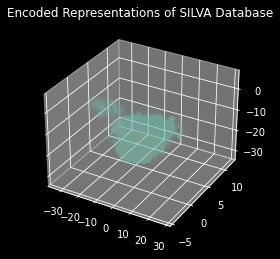

In [49]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

x1, y1, z1 = zip(*(experimental_seq_reps))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, y1, z1, alpha=.02, marker='o')
ax.set_title("Encoded Representations of SILVA Database")
plt.show()

In [50]:
archaea = experimental_seq_reps[tax[:, 0] == 'Archaea'][:500]
bacteria = experimental_seq_reps[tax[:, 0] == 'Bacteria'][:500]
eukaryota = experimental_seq_reps[tax[:, 0] == 'Eukaryota'][:500]

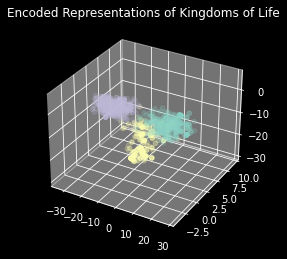

In [51]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

x1, y1, z1 = zip(*archaea)
x2, y2, z2 = zip(*bacteria)
x3, y3, z3 = zip(*eukaryota)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, y1, z1, alpha=.2, marker='o')
ax.scatter(x2, y2, z2, alpha=.2, marker='o')
ax.scatter(x3, y3, z3, alpha=.2, marker='o')
ax.set_title("Encoded Representations of Kingdoms of Life")
plt.show()

### 2D Compressor

In [59]:
import tensorflow as tf
from tensorflow.keras import layers
inputs = layers.Input((3,))
bn = layers.Dense(2)(inputs)
l2_enc = tf.keras.Model(inputs=inputs, outputs=bn)
out = layers.Dense(3)(bn)
l2_ae = tf.keras.Model(inputs=inputs, outputs=out)
l2_ae.compile(optimizer='adam',
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
l2_ae.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_17 (Dense)            (None, 2)                 8         
                                                                 
 dense_18 (Dense)            (None, 3)                 9         
                                                                 
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [60]:
l2_ae.fit(experimental_seq_reps, experimental_seq_reps, validation_split=.1,
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=1, monitor='val_loss')],
            batch_size=100,
            epochs=100)

Epoch 1/100
1625/1625 [==============================] - 8s 5ms/step - loss: 10.4481 - mean_absolute_error: 1.6269 - val_loss: 0.1573 - val_mean_absolute_error: 0.2752
Epoch 2/100
1625/1625 [==============================] - 8s 5ms/step - loss: 0.0676 - mean_absolute_error: 0.1645 - val_loss: 0.0436 - val_mean_absolute_error: 0.1485
Epoch 3/100
1625/1625 [==============================] - 8s 5ms/step - loss: 0.0319 - mean_absolute_error: 0.1140 - val_loss: 0.0237 - val_mean_absolute_error: 0.1126
Epoch 4/100
1625/1625 [==============================] - 7s 5ms/step - loss: 0.0154 - mean_absolute_error: 0.0786 - val_loss: 0.0080 - val_mean_absolute_error: 0.0646
Epoch 5/100
1625/1625 [==============================] - 8s 5ms/step - loss: 0.0067 - mean_absolute_error: 0.0440 - val_loss: 0.0026 - val_mean_absolute_error: 0.0318
Epoch 6/100
1625/1625 [==============================] - 8s 5ms/step - loss: 0.0054 - mean_absolute_error: 0.0290 - val_loss: 0.0022 - val_mean_absolute_error: 0.02

In [58]:
l2_ae.save_weights('Models/silva_classifier_l2.h5')

In [64]:
l2_ae.load_weights('Models/silva_classifier_l2.h5')

In [65]:
seqs_2d = l2_enc(experimental_seq_reps)

In [73]:
rng = np.random.default_rng()
archaea = seqs_2d[tax[:, 0] == 'Archaea']
archaea_samp = archaea.numpy()[(a_s := rng.integers(0, archaea.shape[0], 1000))]
bacteria = seqs_2d[tax[:, 0] == 'Bacteria']
bacteria_samp = bacteria.numpy()[(b_s := rng.integers(0, bacteria.shape[0], 1000))]
eukaryota = seqs_2d[tax[:, 0] == 'Eukaryota']
eukaryota_samp = eukaryota.numpy()[(e_s := rng.integers(0, eukaryota.shape[0], 1000))]

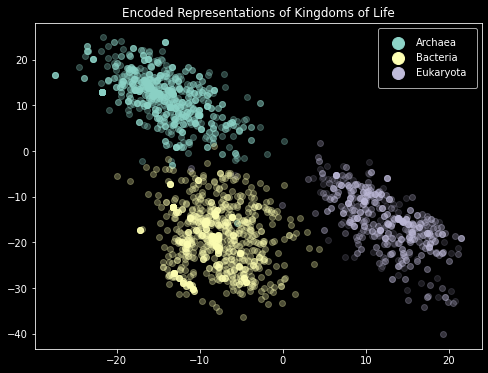

In [74]:
import matplotlib.pyplot as plt

x1, y1 = zip(*archaea_samp)
x2, y2 = zip(*bacteria_samp)
x3, y3= zip(*eukaryota_samp)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.scatter(x1, y1, alpha=.3, marker='o')
ax.scatter(x2, y2, alpha=.3, marker='o')
ax.scatter(x3, y3, alpha=.15, marker='o')
ax.set_title("Encoded Representations of Kingdoms of Life")
leg = plt.legend(['Archaea', 
                  'Bacteria',
                  'Eukaryota'],
                markerscale=2,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.show()

### Statistical Test

In [79]:
rng = np.random.default_rng()
cont = np.concatenate([archaea_samp, eukaryota_samp])
rng.shuffle(cont)

In [80]:
from scipy.spatial import distance_matrix
exp_dist = distance_matrix(eukaryota_samp, bacteria_samp)
cont_dist = distance_matrix(cont[:500], cont[500:])

In [81]:
exp_mindist = exp_dist.min(axis=1)
cont_mindist = cont_dist.min(axis=1)

In [82]:
from scipy.stats import ttest_ind
t, p = ttest_ind(exp_mindist, cont_mindist, equal_var=False)
t, p

(96.71736708335534, 0.0)

### Encodings vs Sequence Alignment

In [7]:
samp_ind = rng.integers(0, seq_reps.shape[0], 1000)
sampa, sampb = samp_ind[:500], samp_ind[500:]
rep_sampa, rep_sampb = seq_reps[sampa], seq_reps[sampb]
seq_sampa, seq_sampb = seqs[sampa].argmax(axis=-1), seqs[sampb].argmax(axis=-1)

NameError: name 'rng' is not defined

In [ ]:
codes = BASES + ['N']
def to_str(s):
    return ''.join(codes[i] for i in s)

def decode(sample):
    str_seq_samp = []
    for i in sample:
        str_seq_samp.append(to_str(i))
    return np.asarray(str_seq_samp)
seq_sampa = decode(seq_sampa)
seq_sampb = decode(seq_sampb)

In [ ]:
from skbio.alignment import local_pairwise_align_ssw
from skbio.sequence import RNA
def score(a, b):
    return local_pairwise_align_ssw(RNA(a), RNA(b))[1]
aln_scores = np.empty((len(seq_sampa),))
for i in range(len(seq_sampa)):
    aln_scores[i] = score(seq_sampa[i], seq_sampb[i])
plt.hist(aln_scores)
plt.show()

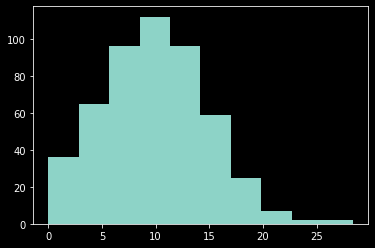

In [108]:
from scipy.spatial.distance import euclidean
euclidean_dists = np.empty((len(rep_sampa),))
for i in range(len(rep_sampa)):
    euclidean_dists[i] = euclidean(rep_sampa[i], rep_sampb[i])
plt.hist(euclidean_dists)
plt.show()

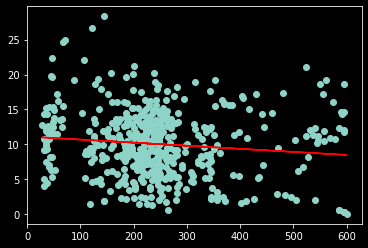

In [109]:
plt.scatter(aln_scores, euclidean_dists)
a, b = np.polyfit(aln_scores, euclidean_dists, 1)
plt.plot(aln_scores, a * aln_scores + b, 'r')
plt.show()

### Phylum-Level Test

In [73]:
rng = np.random.default_rng()
bacteria = seqs_2d[tax[:, 0] == 'Bacteria']
bacteria_samp = bacteria.numpy()[(b_s := rng.integers(0, bacteria.shape[0], 1000))]

In [119]:
a, b = np.unique(tax[tax[:, 0] == 'Bacteria'][:, 1], return_counts=True)
genuses = a[b > 500]

In [138]:
plottable = np.isin(tax[:, 1], genuses)
to_plot = np.zeros((np.nonzero(plottable)[0].shape[0], genuses.shape[0]))
for i in range(len(genuses)):
    to_plot[tax[plottable][:, 1] == genuses[i], i] = 1
plottable_seqs = seqs_2d[plottable].T

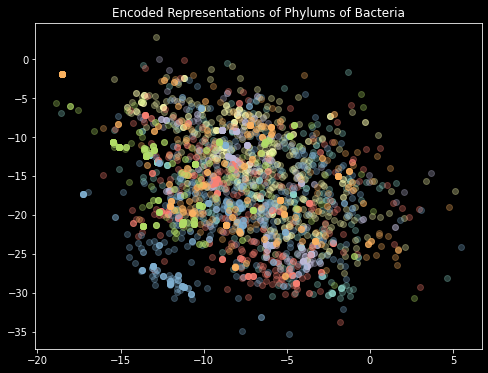

In [161]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
for i in to_plot.T:
    pop = plottable_seqs[i.astype(bool)]
    samp = rng.integers(0, len(pop), 500)
    x, y = zip(*pop.numpy()[samp])
    ax.scatter(x, y, alpha=.3, marker='o')
ax.set_title("Encoded Representations of Phylums of Bacteria")
# leg = plt.legend(['Archaea', 
#                   'Bacteria',
#                   'Eukaryota'],
#                 markerscale=2,
#                 borderpad=1)
# for lh in leg.legendHandles:
#     lh.set_alpha(1)
plt.show()

## Distance Estimation (Siamese Approach)

In [6]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [7]:
codes = BASES + ['N']
def to_str(s):
    return ''.join(codes[i] for i in s)

def decode(sample):
    str_seq_samp = []
    for i in tqdm(sample):
        str_seq_samp.append(to_str(i))
    return np.asarray(str_seq_samp)
str_seqs = decode(seqs.argmax(axis=-1))

  0%|          | 0/180516 [00:00<?, ?it/s]

In [8]:
from sklearn.model_selection import train_test_split
a, b, enc_in_a, enc_in_b = train_test_split(str_seqs, seqs, test_size=.5)
from Bio import pairwise2
def score(pair):
    return pairwise2.align.localxx(pair[0], pair[1], score_only=True)

with mp.Pool() as p:
    aln_scores = np.array(list(tqdm(p.imap(score, zip(a, b), chunksize=1000), total=a.shape[0])))

  0%|          | 0/90258 [00:00<?, ?it/s]

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

inputs = layers.Input((300, 5))
res = layers.Reshape((100, 5 * 3))(inputs)
trans = TransformerBlock(5 * 3, 2, 100)(res)
norm = layers.BatchNormalization()(trans)
conv = layers.Conv1D(20, 3)(norm)
mp = layers.MaxPooling1D()(conv)
res2 = layers.Reshape((49 * 20,))(mp)
norm = layers.BatchNormalization()(res2)
out = layers.Dense(3)(norm)

embeddings = tf.keras.Model(inputs=inputs, outputs=out)

In [6]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, a, b):
        return tf.reduce_sum(tf.square(a - b), -1)

In [7]:
inputa = layers.Input((300, 5))
inputb = layers.Input((300, 5))
distances = DistanceLayer()(
    embeddings(inputa),
    embeddings(inputb),
)
siamese_network = tf.keras.Model(inputs=[inputa, inputb], outputs=distances)
siamese_network.compile(optimizer='adam',
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
siamese_network.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 300, 5)]     0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 300, 5)]     0           []                               
                                                                                                  
 model_2 (Functional)           (None, 3)            12923       ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 distance_layer (DistanceLayer)  (None,)             0           ['model_2[0][0]',          

In [440]:
y = 1 / aln_scores
siamese_network.fit([enc_in_a, enc_in_b], y, validation_split=.1,
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=1, monitor='val_loss'),
                      tf.keras.callbacks.ModelCheckpoint(filepath='Models/silva_siamese.ckpt',
                                                        save_best_only=True,
                                                        save_weights_only=True)],
            batch_size=100,
            epochs=100)

Epoch 1/100
813/813 [==============================] - 47s 53ms/step - loss: 1.1209 - mean_absolute_error: 0.5454 - val_loss: 0.1878 - val_mean_absolute_error: 0.3870
Epoch 2/100
813/813 [==============================] - 43s 53ms/step - loss: 0.1573 - mean_absolute_error: 0.3264 - val_loss: 0.1280 - val_mean_absolute_error: 0.2975
Epoch 3/100
813/813 [==============================] - 43s 53ms/step - loss: 0.1349 - mean_absolute_error: 0.3004 - val_loss: 0.1105 - val_mean_absolute_error: 0.2702
Epoch 4/100
813/813 [==============================] - 43s 53ms/step - loss: 0.1182 - mean_absolute_error: 0.2790 - val_loss: 0.1089 - val_mean_absolute_error: 0.2629
Epoch 5/100
813/813 [==============================] - 43s 53ms/step - loss: 0.1073 - mean_absolute_error: 0.2651 - val_loss: 0.1033 - val_mean_absolute_error: 0.2599
Epoch 6/100
813/813 [==============================] - 43s 53ms/step - loss: 0.1043 - mean_absolute_error: 0.2618 - val_loss: 0.1024 - val_mean_absolute_error: 0.255

In [14]:
siamese_network.save_weights('Models/silva_siamese.h5')

In [8]:
siamese_network.load_weights('Models/silva_siamese.h5')

In [9]:
seq_reps_siamese = embeddings.predict(seqs, verbose=1)

5642/5642 [==============================] - 64s 11ms/step


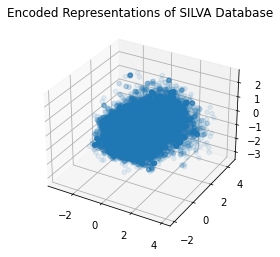

In [17]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

x1, y1, z1 = seq_reps_siamese.T
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, y1, z1, alpha=.1, marker='o')
ax.set_title("Encoded Representations of SILVA Database")
plt.show()

In [10]:
import tensorflow as tf
from tensorflow.keras import layers
inputs = layers.Input((3,))
bn = layers.Dense(2)(inputs)
l2_enc = tf.keras.Model(inputs=inputs, outputs=bn)
out = layers.Dense(3)(bn)
l2_ae = tf.keras.Model(inputs=inputs, outputs=out)
l2_ae.compile(optimizer='adam',
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
l2_ae.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_10 (Dense)            (None, 2)                 8         
                                                                 
 dense_11 (Dense)            (None, 3)                 9         
                                                                 
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [444]:
l2_ae.fit(seq_reps_siamese, seq_reps_siamese, validation_split=.1,
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=1, monitor='val_loss')],
            batch_size=100,
            epochs=100)

Epoch 1/100
1625/1625 [==============================] - 8s 5ms/step - loss: 0.0317 - mean_absolute_error: 0.1257 - val_loss: 0.0110 - val_mean_absolute_error: 0.0776
Epoch 2/100
1625/1625 [==============================] - 8s 5ms/step - loss: 0.0154 - mean_absolute_error: 0.0845 - val_loss: 0.0119 - val_mean_absolute_error: 0.0709


In [109]:
l2_ae.save_weights('Models/silva_siamese_l2ae.h5')

In [11]:
l2_ae.load_weights('Models/silva_siamese_l2ae.h5')

In [12]:
siamese_2d = l2_enc(seq_reps_siamese)

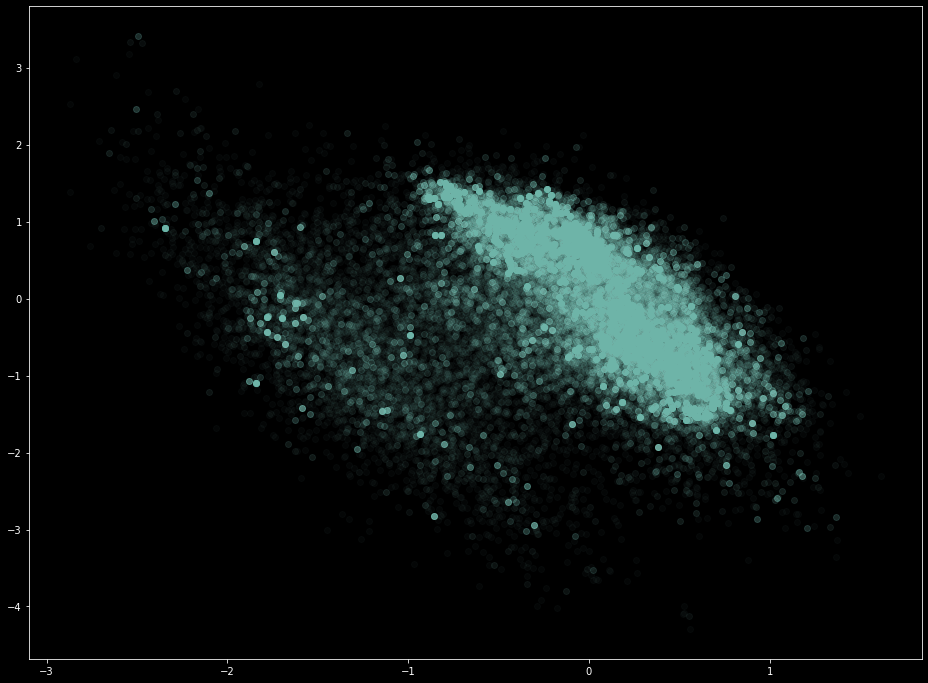

In [26]:
f = plt.figure(figsize=(16, 12))
plt.scatter(siamese_2d[:, 0], siamese_2d[:, 1], alpha=.03)
plt.show()

In [22]:
archaea = siamese_2d[tax[:, 0] == 'Archaea']
bacteria = siamese_2d[tax[:, 0] == 'Bacteria']
eukaryota = siamese_2d[tax[:, 0] == 'Eukaryota']

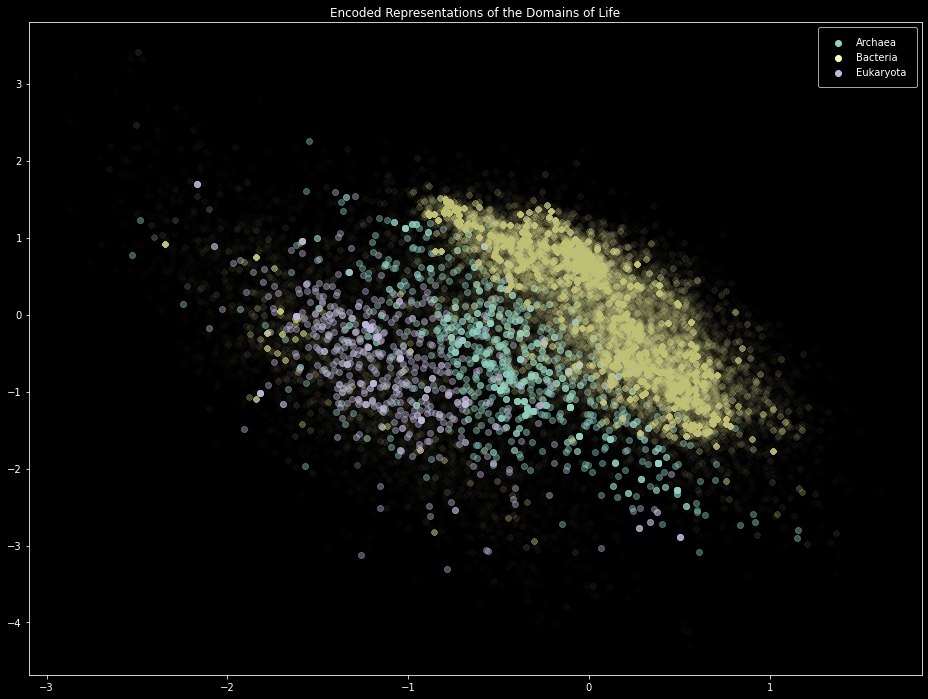

In [23]:
f = plt.figure(figsize=(16, 12))
plt.scatter(archaea[:, 0], archaea[:, 1], alpha=.4)
plt.scatter(bacteria[:, 0], bacteria[:, 1], alpha=.015)
plt.scatter(eukaryota[:, 0], eukaryota[:, 1], alpha=.4)
leg = plt.legend(['Archaea', 
                  'Bacteria',
                  'Eukaryota'],
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.title('Encoded Representations of the Domains of Life')
plt.show()

### Encodings vs Sequence Alignment

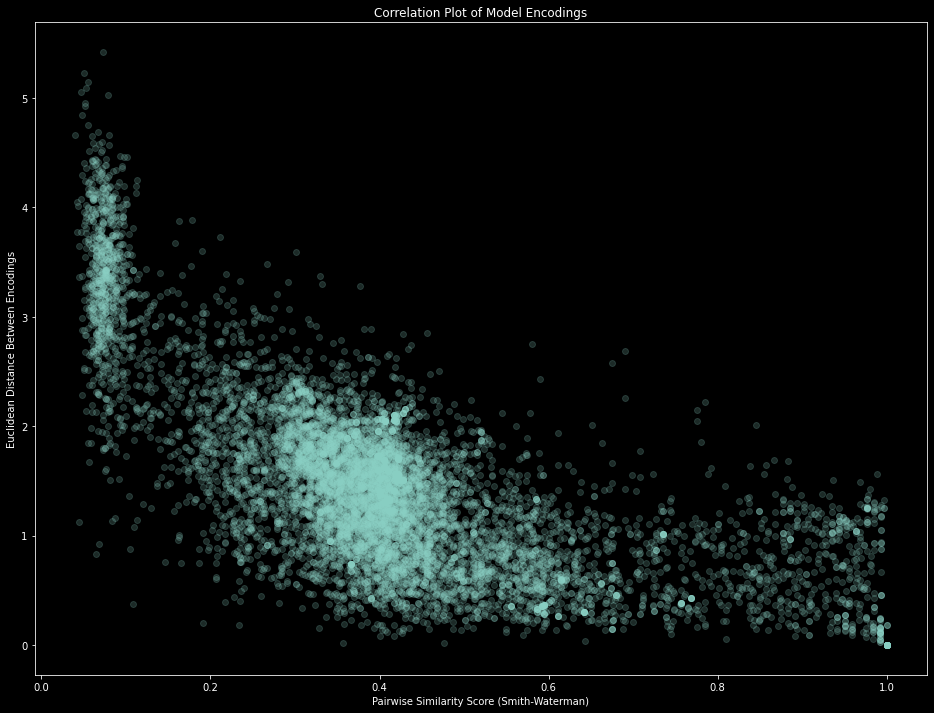

In [34]:
import random
from scipy.spatial.distance import euclidean
from skbio.alignment import local_pairwise_align_ssw
from skbio.sequence import RNA
codes = BASES + ['N']
def to_str(s):
    return ''.join(codes[i] for i in s)
def evaluate():
    a = random.randint(0, seq_reps_siamese.shape[0] - 1)
    b = random.randint(0, seq_reps_siamese.shape[0] - 1)
    pred = euclidean(seq_reps_siamese[a], seq_reps_siamese[b])
    first = to_str(seqs[a].argmax(-1))
    second = to_str(seqs[b].argmax(-1))
    score = local_pairwise_align_ssw(RNA(first), RNA(second))[1] / 600
    return [score, pred]
results = np.asarray([evaluate() for i in range(10000)])
f = plt.figure(figsize=(16, 12))
plt.scatter(results[:, 0], results[:, 1], alpha=.2)
plt.xlabel('Pairwise Similarity Score (Smith-Waterman)')
plt.ylabel('Euclidean Distance Between Encodings')
plt.title('Correlation Plot of Model Encodings')
plt.show()

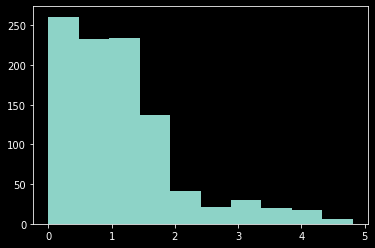

In [32]:
plt.hist(np.abs(results[:, 0] - results[:, 1]))
plt.show()

### Phylum-Level Test

In [45]:
a, b = np.unique(tax[tax[:, 0] == 'Bacteria'][:, 1], return_counts=True)
genuses = a[b > 1000]

In [46]:
plottable = np.isin(tax[:, 1], genuses)
to_plot = np.zeros((np.nonzero(plottable)[0].shape[0], genuses.shape[0]))
for i in range(len(genuses)):
    to_plot[tax[plottable][:, 1] == genuses[i], i] = 1
plottable_seqs = siamese_2d[plottable].numpy()

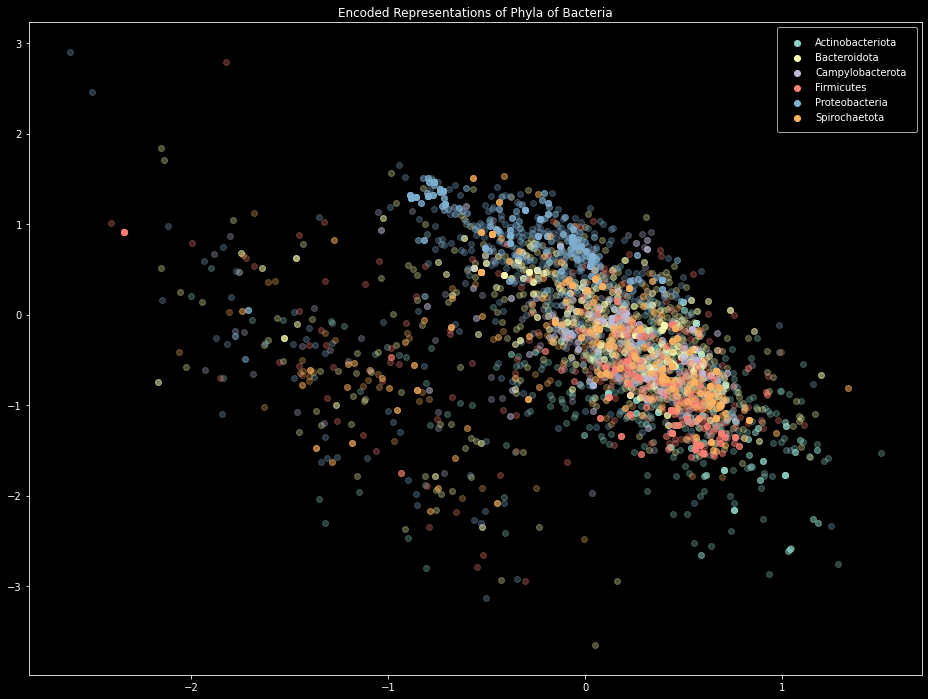

In [47]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
for i in to_plot.T:
    pop = plottable_seqs[i.astype(bool)]
    samp = rng.integers(0, len(pop), 1000)
    x, y = zip(*pop[samp])
    ax.scatter(x, y, alpha=.3, marker='o')
ax.set_title("Encoded Representations of Phyla of Bacteria")
leg = plt.legend(genuses,
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.show()

In [48]:
a, b = np.unique(tax[tax[:, 1] == 'Proteobacteria'][:, 2], return_counts=True)
genuses = a[b > 500]

In [49]:
plottable = np.isin(tax[:, 2], genuses)
to_plot = np.zeros((np.nonzero(plottable)[0].shape[0], genuses.shape[0]))
for i in range(len(genuses)):
    to_plot[tax[plottable][:, 2] == genuses[i], i] = 1
plottable_seqs = siamese_2d[plottable].numpy()

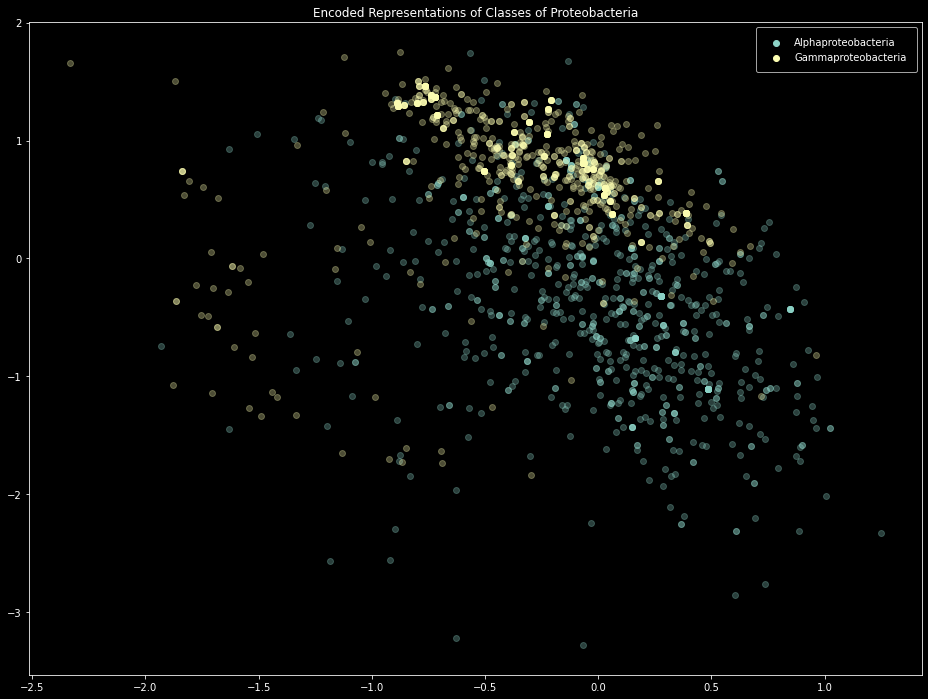

In [52]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
for i in to_plot.T:
    pop = plottable_seqs[i.astype(bool)]
    samp = rng.integers(0, len(pop), 1000)
    x, y = zip(*pop[samp])
    ax.scatter(x, y, alpha=.3, marker='o')
ax.set_title("Encoded Representations of Classes of Proteobacteria")
leg = plt.legend(genuses,
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.show()

## ANC Data

### Load/Preprocess

In [53]:
label_map = {
    "S002": "black",
    "S001": "grey",
    "S003": "unpigmented"
}
def read_ion_reporter(path):
    import os
    import pandas as pd
    import numpy as np
    from Bio import SeqIO
    from tqdm.notebook import tqdm
    import re

    paths = np.array([])  # Get paths to all fasta files
    for root, dirs, files in os.walk(path):
        paths = np.append(paths, [os.path.join(root, i) for i in files if i.endswith(".fasta")])

    def read(i):  # Function to parse a fasta file and get all records
        s = np.array([record for index, record in enumerate(SeqIO.parse(i, "fasta"))] + [0], dtype=object)
        s = s[:-1]  # We append 0 and remove it so that single element arrays get parsed as such
        l = np.full_like(s, label_map[i.split("/")[-1][:4]])
        return s, l

    seqs, labels, desc = np.array([]), np.array([]), np.array([])
    for i in paths:  # Parse all sequences, generate labels
        s, l = read(i)
        seqs = np.append(seqs, s)
        labels = np.append(labels, l)
    # flattened_seqs = np.concatenate(seqs)  # Flatten because we don't care about which sample the data came from
    string_seqs = np.vectorize(lambda i: str(i.seq))(seqs)  # Convert to strings
    descriptions = np.vectorize(lambda i: i.description)(seqs)

    return string_seqs, labels, descriptions

In [54]:
arlington, arlington_labels, arlington_desc = read_ion_reporter("Data/Arlington Processed")

#### Header Parsing

In [55]:
import re
def get_size(s: str):
    parts = s.split('|')
    idx = -1
    for i in range(len(parts)):
        if re.search(r'\.', parts[i]):
            idx = i
            break
    if idx == -1:
        return 0
    return len(parts[i + 1:])

import numpy as np
arlington_known = np.vectorize(get_size)(arlington_desc) != 0
arlington = arlington[arlington_known]
arlington_labels = arlington_labels[arlington_known]
arlington_desc = arlington_desc[arlington_known]

def get_tax(s: str):
    parts = s.split('|')
    for i in range(len(parts)):
        if re.search(r'\.', parts[i]):
            break
    tax = [x.strip('[]') for x in parts[i + 1:-1]]
    unc = ["UNKNOWN"] * 6
    cond = ['/' not in i and 'sp.' not in i for i in tax]
    return np.where(cond, tax, unc)

arlington_tax = np.empty((arlington_desc.shape[0], 6), dtype=object)
for i in range(arlington_desc.shape[0]):
    arlington_tax[i, :] = get_tax(arlington_desc[i])

def get_conf(s: str):
    parts = s.split('|')
    for i in range(len(parts)):
        if re.search(r'\.', parts[i]):
            break
    return float(parts[i])

arlington_conf = np.vectorize(get_conf)(arlington_desc)

def get_abund(s: str):
    parts = s.split('|')
    for i in range(len(parts)):
        if re.search(r'\.', parts[i]):
            break
    return int(parts[i - 1])

arlington_abund = np.vectorize(get_abund)(arlington_desc)

#### Sequence Encoding

In [56]:
def preprocess_reads(x):
    from tqdm.notebook import tqdm
    from sklearn import preprocessing
    import numpy as np

    BASES = ["A", "T", "G", "C"]

    LENGTH = 300

    # mask = np.vectorize(len)(x) >= LENGTH
    seqs = np.vectorize(lambda i: i[:LENGTH])(x)

    print("Encoding sequences...")
    # Sequence encoding
    def encode_seq(seq: str):  # Function to encode a sequence using one-hot encoding
        idx = [BASES.index(char) for char in seq]
        return [[(1 if j == i else 0) for j in range(5)] for i in idx]
    # Time consuming step, vectorize if possible!!!
    final_seqs = np.empty((seqs.shape[0], LENGTH, 5), dtype=np.int32)  # Init empty array
    for i in tqdm(range(len(seqs))):  # Iterate over sequences
        encoded = encode_seq(seqs[i][:LENGTH])  # Encode each sequence
        final_seqs[i] = np.concatenate([np.zeros((LENGTH - len(encoded), 5)), encoded])

    return final_seqs

In [57]:
arlington_processed = preprocess_reads(arlington)

Encoding sequences...


  0%|          | 0/17142 [00:00<?, ?it/s]

#### Variable Region Separation

##### Preprocessing

In [58]:
def get_variable_region(i):  # Function to get the variable region from the record's description
    header_parts = i.split("|")  # Header is | delimited
    variable_region = "UNKNOWN"  # Default variable region
    for val in header_parts:  # Iterate over the header parts
        if result := re.search(r"^V\d+", val):  # Match any pattern starting with a V and ending with digits
            variable_region = val  # Set variable region to the text in the matched part of the header
            break
    return variable_region

import numpy as np
v_regions = np.vectorize(get_variable_region)(arlington_desc)

known_mask = v_regions != 'UNKNOWN'
known_seqs, known_labels = arlington_processed[known_mask], v_regions[known_mask]

from sklearn.preprocessing import LabelBinarizer
bn = LabelBinarizer()
v_regions_enc = bn.fit_transform(known_labels)

##### NN Classifier

In [59]:
import tensorflow as tf
inputs = tf.keras.layers.Input((300, 5))
hidden = tf.keras.layers.Dense(300, activation='relu')(inputs)
flat = tf.keras.layers.Flatten()(hidden)
outputs = tf.keras.layers.Dense(v_regions_enc.shape[1], activation='softmax')(flat)

v_region_classifier = tf.keras.Model(inputs=inputs, outputs=outputs)
v_region_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
v_region_classifier.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 300, 5)]          0         
                                                                 
 dense_12 (Dense)            (None, 300, 300)          1800      
                                                                 
 flatten (Flatten)           (None, 90000)             0         
                                                                 
 dense_13 (Dense)            (None, 6)                 540006    
                                                                 
Total params: 541,806
Trainable params: 541,806
Non-trainable params: 0
_________________________________________________________________


In [60]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(known_seqs, v_regions_enc, test_size=.2)
import tensorflow as tf
v_region_classifier.fit(x_train, y_train, validation_data=(x_val, y_val),
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=1, monitor='val_loss')],
                       batch_size=100,
                       epochs=100)

Epoch 1/100
69/69 [==============================] - 1s 16ms/step - loss: 0.1103 - accuracy: 0.9697 - val_loss: 0.0234 - val_accuracy: 0.9965
Epoch 2/100
69/69 [==============================] - 1s 12ms/step - loss: 0.0047 - accuracy: 0.9994 - val_loss: 0.0141 - val_accuracy: 0.9983
Epoch 3/100
69/69 [==============================] - 1s 12ms/step - loss: 0.0012 - accuracy: 0.9999 - val_loss: 0.0141 - val_accuracy: 0.9983
Epoch 4/100
69/69 [==============================] - 1s 13ms/step - loss: 5.1041e-04 - accuracy: 1.0000 - val_loss: 0.0140 - val_accuracy: 0.9983
Epoch 5/100
69/69 [==============================] - 1s 13ms/step - loss: 3.1353e-04 - accuracy: 1.0000 - val_loss: 0.0141 - val_accuracy: 0.9983


##### Classify All Seqs

In [61]:
unknown_labels = v_region_classifier.predict(arlington_processed[~known_mask], verbose=1)
int_predictions = unknown_labels.argmax(axis=1)
predictions = np.vectorize(lambda i: bn.classes_[i])(int_predictions)
certainty = unknown_labels.max(axis=1)
print(certainty.shape, np.nonzero(certainty > .99)[0].shape)  # We can classify almost everything with 99% confidence

v_region_labels = np.full_like(v_regions, 'UNKNOWN')
v_region_labels[known_mask] = known_labels
a = v_region_labels[~known_mask]
a[certainty > .99] = predictions[certainty > .99]
v_region_labels[~known_mask] = a
print(v_region_labels[v_region_labels != 'UNKNOWN'].shape[0] / v_region_labels.shape[0])
# We successfully classified about 99% of our unknown data

268/268 [==============================] - 1s 4ms/step
(8571,) (8525,)
0.9973165324932913


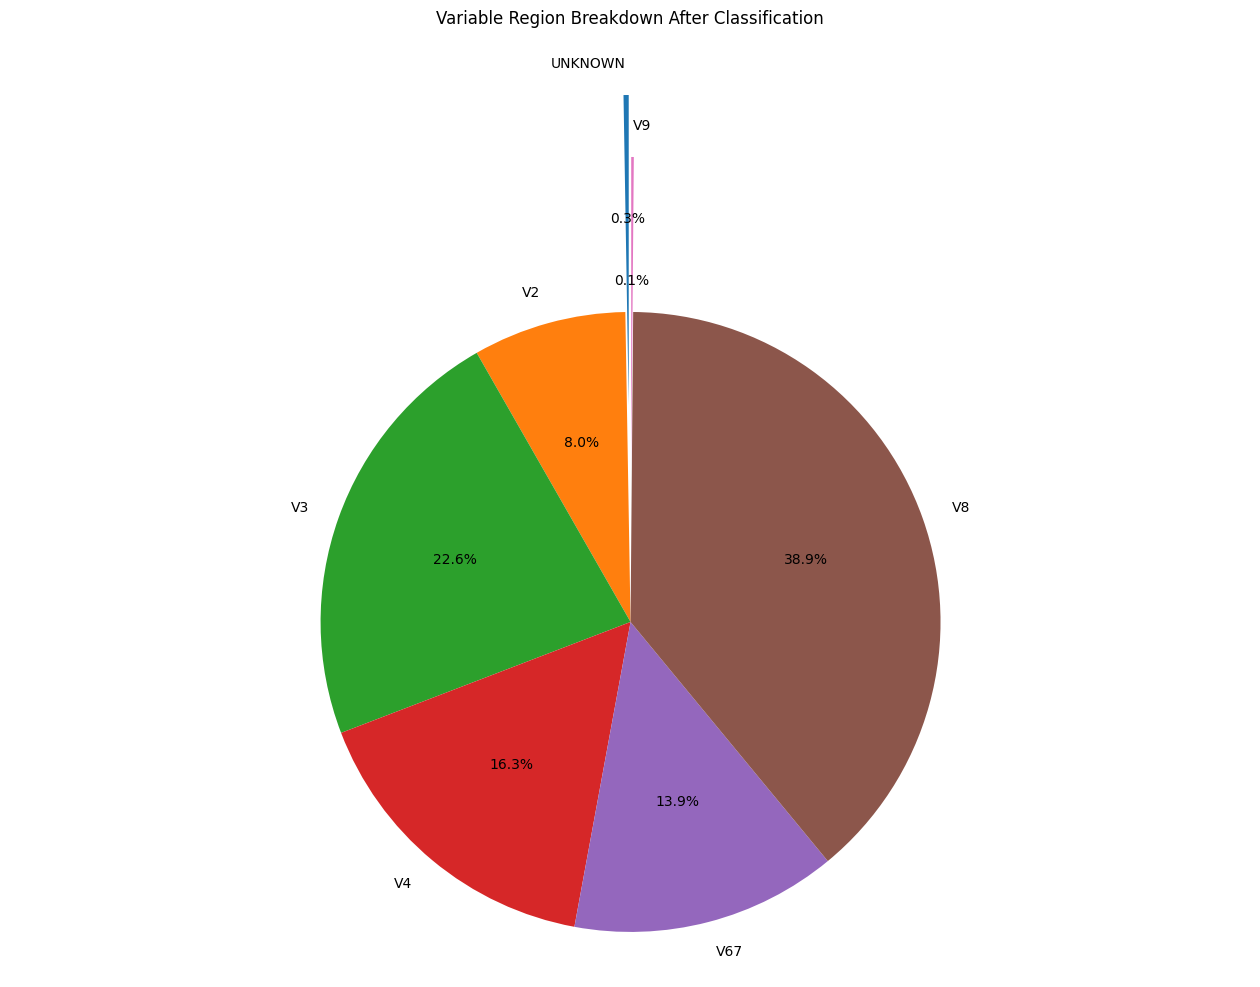

In [71]:
import matplotlib.pyplot as plt
plt.style.use('default')
labels, sizes = np.unique(v_region_labels, return_counts=True)
# s = np.argsort(sizes)
# labels, sizes = labels[s], sizes[s]
fig, ax = plt.subplots(figsize=(16, 12))
ax.pie(sizes, labels=labels, startangle=90, autopct='%1.1f%%', explode=(.7, 0, 0, 0, 0, 0, .5))
ax.axis('equal')
ax.set_title('Variable Region Breakdown After Classification\n')
plt.show()
plt.style.use('dark_background')

## Encode and Visualize

In [72]:
anc_enc = embeddings.predict(arlington_processed, verbose=1)
anc_2d = l2_enc(anc_enc)

536/536 [==============================] - 6s 11ms/step


Text(0.5, 1.0, 'Arlington National Cemetery Stone Surface Biofilm')

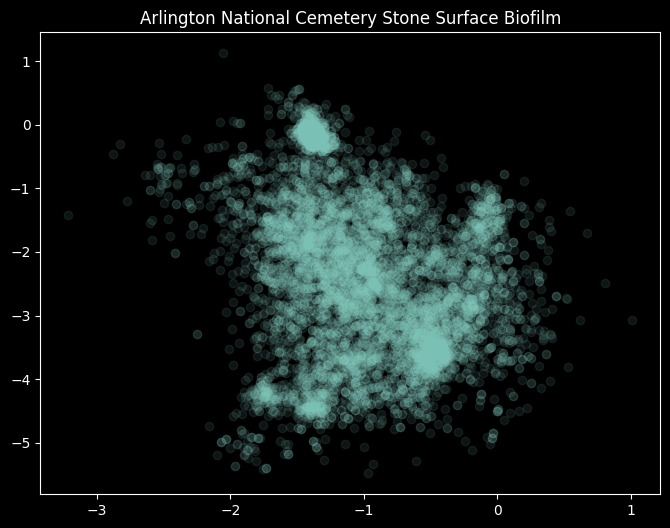

In [75]:
f = plt.figure(figsize=(8, 6))
plt.scatter(anc_2d[:, 0], anc_2d[:, 1], alpha=.05)
plt.title('Arlington National Cemetery Stone Surface Biofilm')

In [76]:
all_phyla, counts = np.unique(arlington_tax[:, 0], return_counts=True)
genuses = all_phyla[counts > 50]

In [77]:
plottable = np.isin(arlington_tax[:, 0], genuses)
to_plot = np.zeros((np.nonzero(plottable)[0].shape[0], genuses.shape[0]))
for i in range(len(genuses)):
    to_plot[arlington_tax[plottable][:, 0] == genuses[i], i] = 1
plottable_seqs = anc_2d[plottable].numpy()

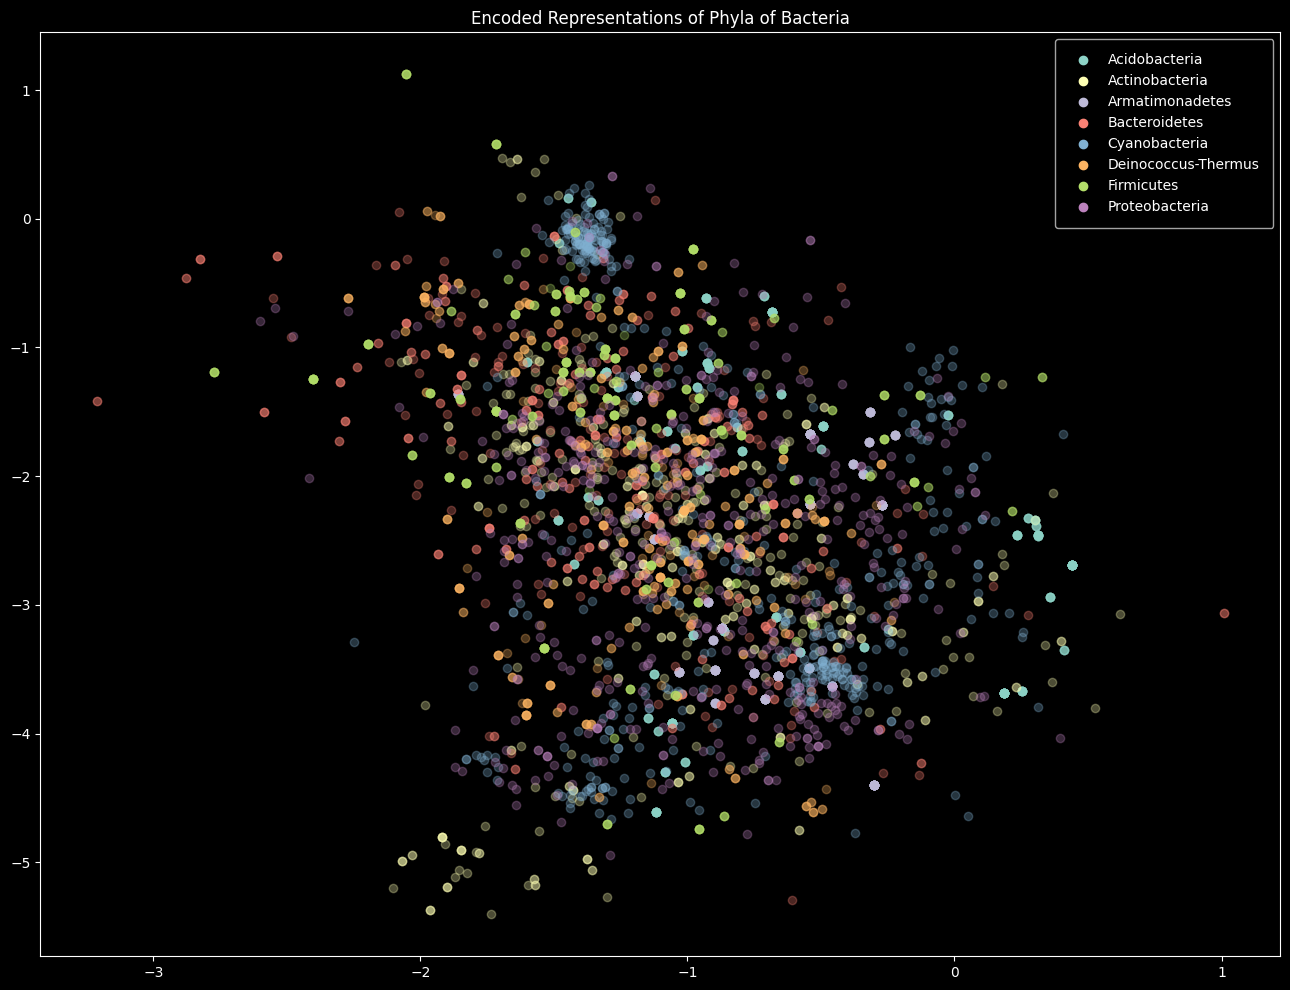

In [78]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
for i in to_plot.T:
    pop = plottable_seqs[i.astype(bool)]
    samp = rng.integers(0, len(pop), 500)
    x, y = zip(*pop[samp])
    ax.scatter(x, y, alpha=.3, marker='o')
ax.set_title("Encoded Representations of Phyla of Bacteria")
leg = plt.legend(genuses,
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.show()

In [81]:
all_regions, counts = np.unique(v_region_labels, return_counts=True)
genuses = all_regions[counts > 50]

In [82]:
plottable = np.isin(v_region_labels, genuses)
to_plot = np.zeros((np.nonzero(plottable)[0].shape[0], genuses.shape[0]))
for i in range(len(genuses)):
    to_plot[v_region_labels[plottable] == genuses[i], i] = 1
plottable_seqs = anc_2d[plottable].numpy()

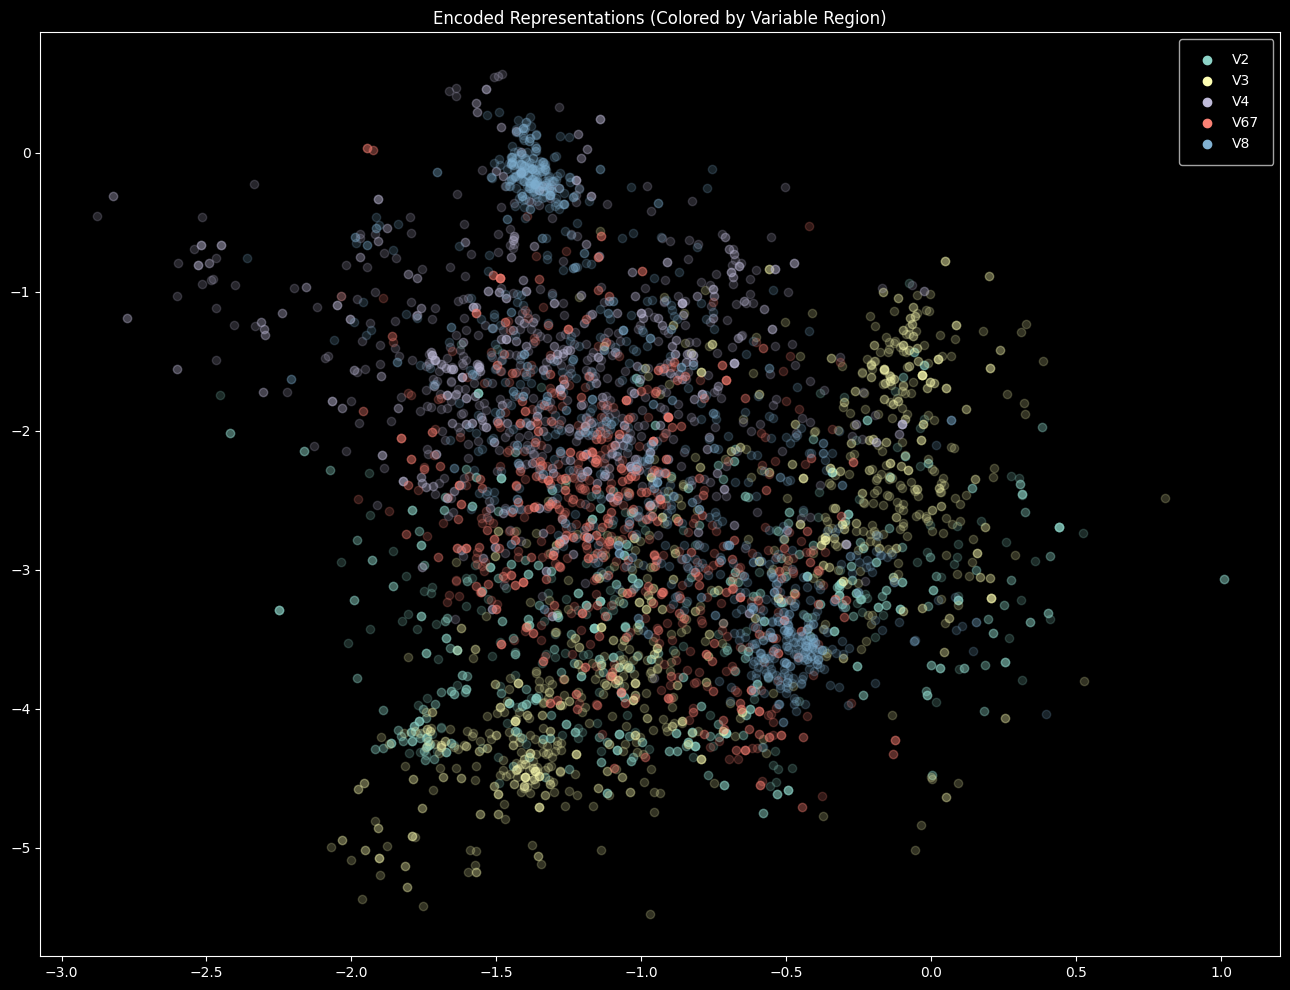

In [83]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
for i in to_plot.T:
    pop = plottable_seqs[i.astype(bool)]
    samp = rng.integers(0, len(pop), 1000)
    x, y = zip(*pop[samp])
    ax.scatter(x, y, alpha=.2, marker='o')
ax.set_title("Encoded Representations (Colored by Variable Region)")
leg = plt.legend(genuses,
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.show()

In [86]:
subset = v_region_labels == 'V8'
arlington_tax_sub = arlington_tax[subset]
anc_2d_sub = anc_2d[subset]
anc_lbl_sub = arlington_labels[subset]

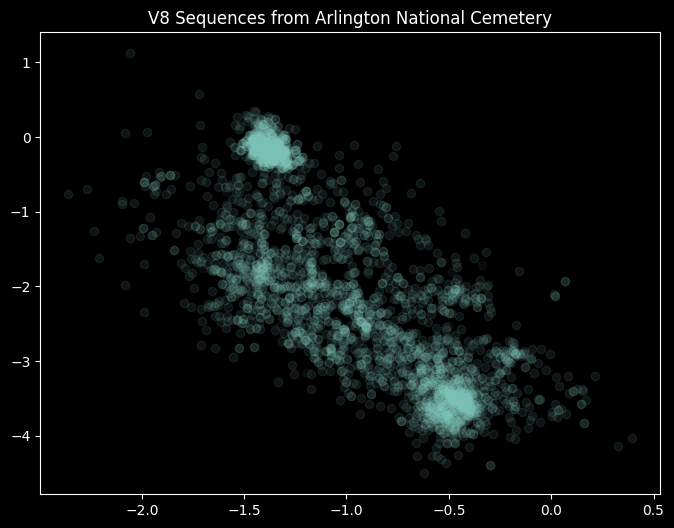

In [87]:
f = plt.figure(figsize=(8, 6))
plt.scatter(anc_2d_sub[:, 0], anc_2d_sub[:, 1], alpha=.05)
plt.title('V8 Sequences from Arlington National Cemetery')
plt.show()

In [88]:
all_phyla, counts = np.unique(arlington_tax_sub[:, 0], return_counts=True)
genuses = all_phyla[counts > 50]

In [89]:
plottable = np.isin(arlington_tax_sub[:, 0], genuses)
to_plot = np.zeros((np.nonzero(plottable)[0].shape[0], genuses.shape[0]))
for i in range(len(genuses)):
    to_plot[arlington_tax_sub[plottable][:, 0] == genuses[i], i] = 1
plottable_seqs = anc_2d_sub[plottable].numpy()

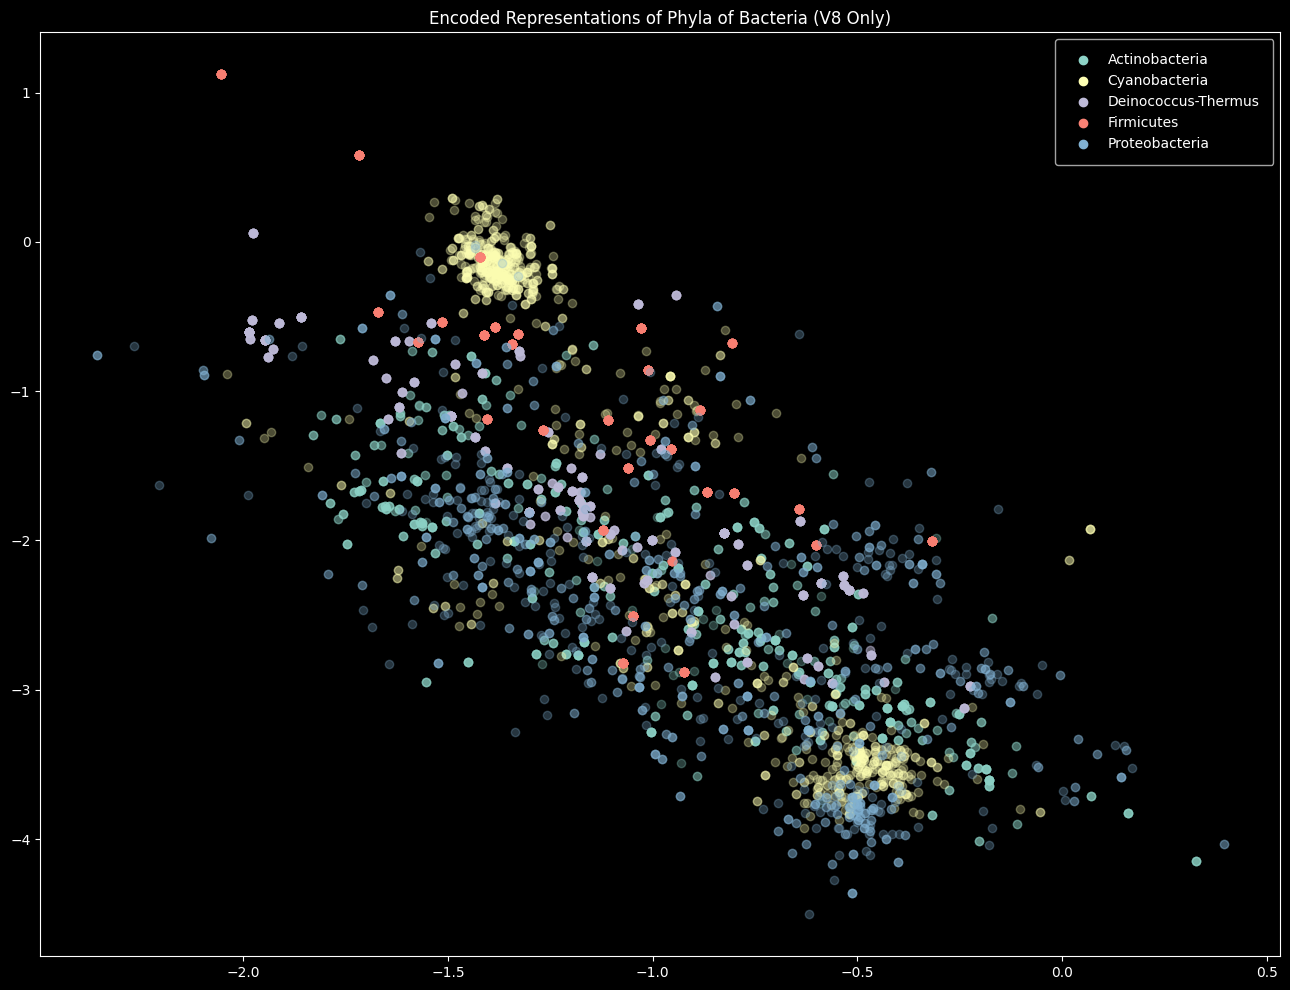

In [91]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
for i in to_plot.T:
    pop = plottable_seqs[i.astype(bool)]
    samp = rng.integers(0, len(pop), 1000)
    x, y = zip(*pop[samp])
    ax.scatter(x, y, alpha=.3, marker='o')
ax.set_title("Encoded Representations of Phyla of Bacteria (V8 Only)")
leg = plt.legend(genuses,
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.show()

In [498]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, n_init=10)
optimal_labels = kmeans.fit_predict(anc_2d_sub)

In [499]:
all_labels, counts = np.unique(optimal_labels, return_counts=True)
genuses = all_labels[counts > 0]

In [500]:
plottable = np.isin(optimal_labels, genuses)
to_plot = np.zeros((np.nonzero(plottable)[0].shape[0], genuses.shape[0]))
for i in range(len(genuses)):
    to_plot[optimal_labels[plottable] == genuses[i], i] = 1
plottable_seqs = anc_2d_sub[plottable].numpy()

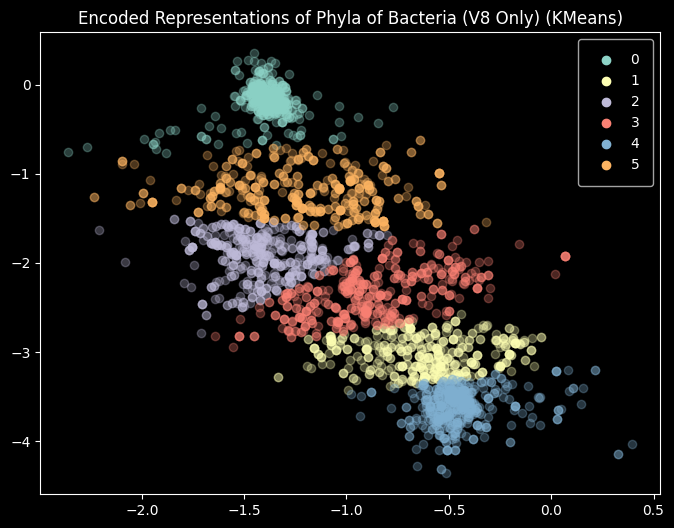

In [501]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
for i in to_plot.T:
    pop = plottable_seqs[i.astype(bool)]
    samp = rng.integers(0, len(pop), 500)
    x, y = zip(*pop[samp])
    ax.scatter(x, y, alpha=.3, marker='o')
ax.set_title("Encoded Representations of Phyla of Bacteria (V8 Only) (KMeans)")
leg = plt.legend(genuses,
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.show()

In [502]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=.075, min_samples=30)
optimal_labels = dbscan.fit_predict(anc_2d_sub)

In [503]:
all_labels, counts = np.unique(optimal_labels, return_counts=True)
genuses = all_labels[counts > 0]

In [504]:
plottable = np.isin(optimal_labels, genuses)
to_plot = np.zeros((np.nonzero(plottable)[0].shape[0], genuses.shape[0]))
for i in range(len(genuses)):
    to_plot[optimal_labels[plottable] == genuses[i], i] = 1
plottable_seqs = anc_2d_sub[plottable].numpy()

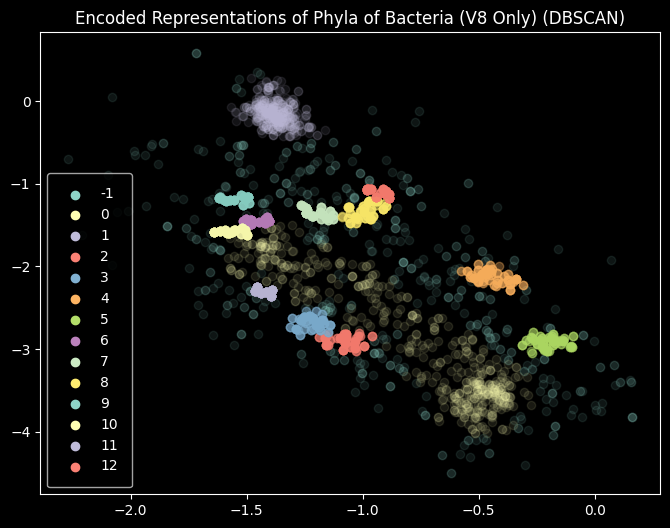

In [505]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
for i in to_plot.T:
    pop = plottable_seqs[i.astype(bool)]
    samp = rng.integers(0, len(pop), 500)
    x, y = zip(*pop[samp])
    ax.scatter(x, y, alpha=.1, marker='o')
ax.set_title("Encoded Representations of Phyla of Bacteria (V8 Only) (DBSCAN)")
leg = plt.legend(genuses,
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.show()

## Significant Difference by Pigment?

### Visualization

In [92]:
all_phyla, counts = np.unique(anc_lbl_sub, return_counts=True)
genuses = all_phyla[counts > 50]

In [93]:
plottable = np.isin(anc_lbl_sub, genuses)
to_plot = np.zeros((np.nonzero(plottable)[0].shape[0], genuses.shape[0]))
for i in range(len(genuses)):
    to_plot[anc_lbl_sub[plottable] == genuses[i], i] = 1
plottable_seqs = anc_2d_sub[plottable].numpy()

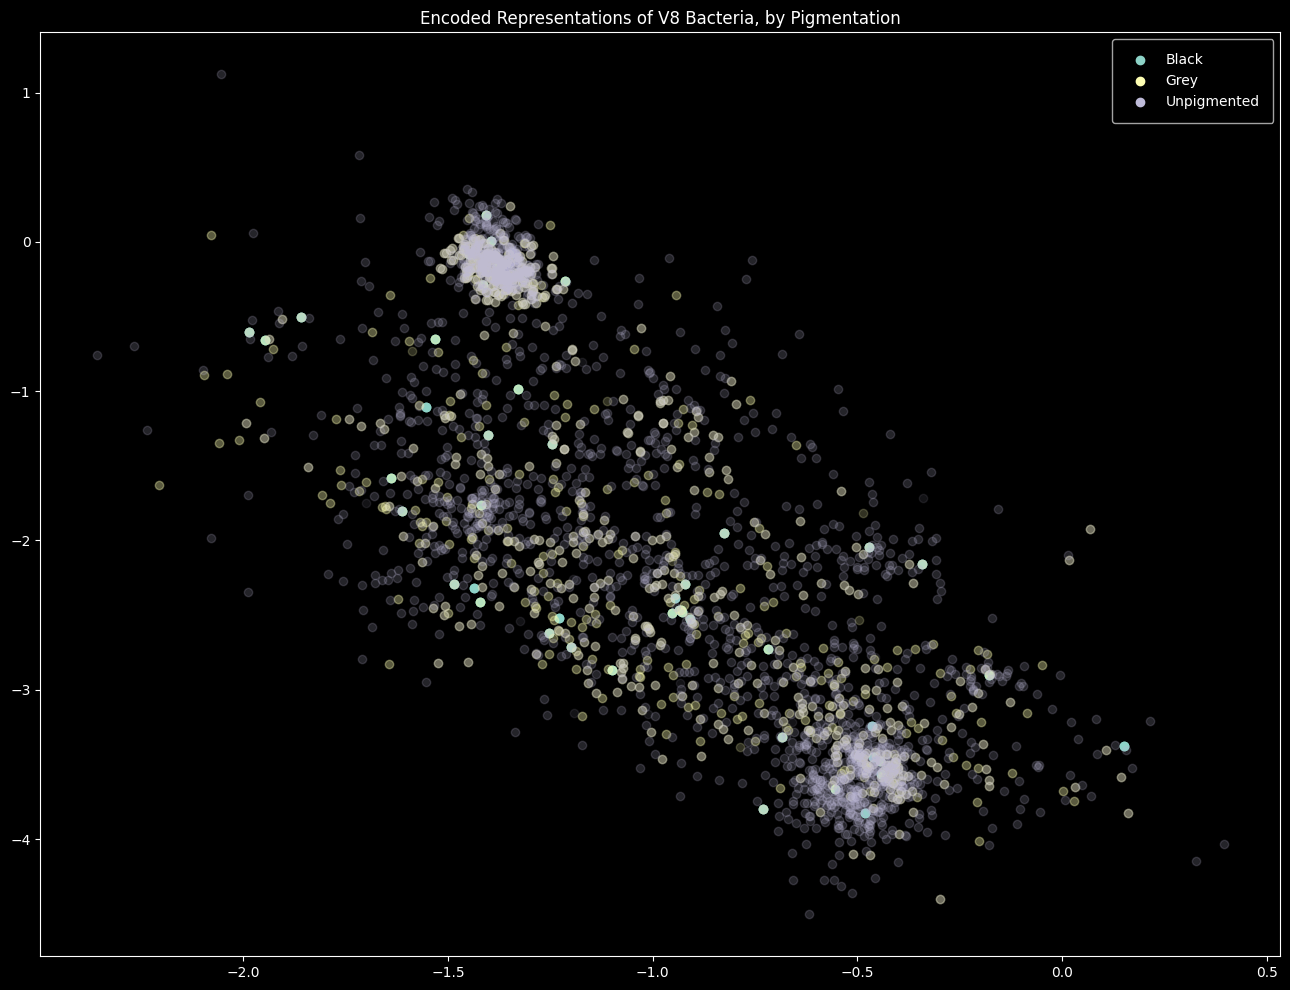

In [94]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
black, grey, unpigmented = anc_lbl_sub == 'black', anc_lbl_sub == 'grey', anc_lbl_sub == 'unpigmented'
plt.scatter(anc_2d_sub[black][:, 0], anc_2d_sub[black][:, 1], alpha=1)
plt.scatter(anc_2d_sub[grey][:, 0], anc_2d_sub[grey][:, 1], alpha=.2)
plt.scatter(anc_2d_sub[unpigmented][:, 0], anc_2d_sub[unpigmented][:, 1], alpha=.1)
ax.set_title("Encoded Representations of V8 Bacteria, by Pigmentation")
leg = plt.legend(['Black', 'Grey', 'Unpigmented'],
                markerscale=1,
                borderpad=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.show()

### Statistical Test

In [95]:
pig = anc_enc[(arlington_labels == 'black') | (arlington_labels == 'gray')]
unpig = anc_enc[arlington_labels == 'unpigmented']
pig_samp = pig[rng.integers(0, pig.shape[0], 500)]
to_sample = rng.integers(0, unpig.shape[0], 1000)
unpig_samp = unpig[to_sample[:500]]
cont_samp = unpig[to_sample[500:]]

In [96]:
from scipy.spatial import distance_matrix
exp_dist = distance_matrix(unpig_samp, pig_samp)
cont_dist = distance_matrix(unpig_samp, cont_samp)

In [97]:
exp_mindist = exp_dist.min(axis=1)
cont_mindist = cont_dist.min(axis=1)

In [98]:
from scipy.stats import ttest_ind
t, p = ttest_ind(exp_mindist, cont_mindist, equal_var=False)
t, p

(8.81952609822075, 5.6645266522121156e-18)

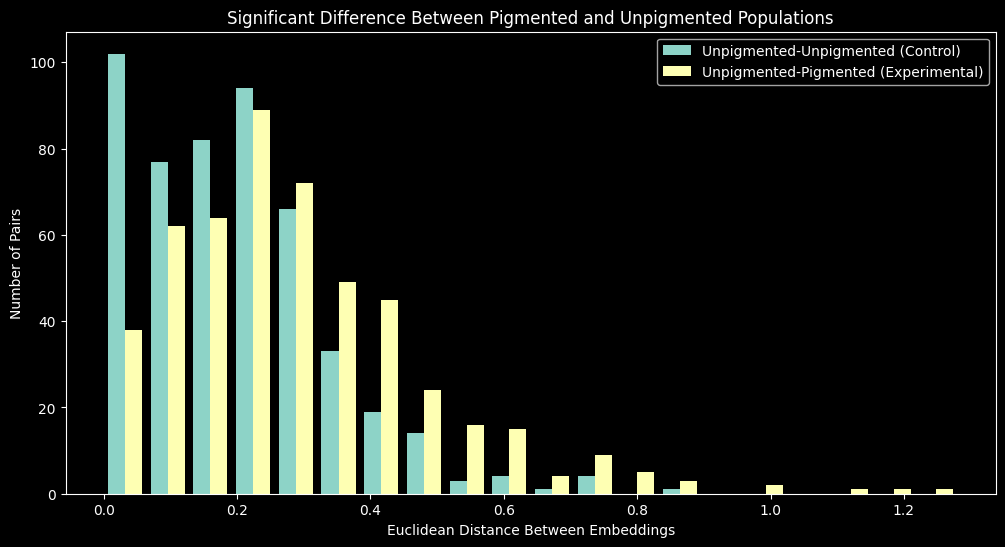

In [99]:
f = plt.figure(figsize=(12, 6))
plt.hist([cont_mindist, exp_mindist], bins=20)
# plt.hist(cont_mindist, bins=[0, .2, .4, .6, .8, 1, 1.2, 1.4, 1.6])
plt.legend(['Unpigmented-Unpigmented (Control)', 'Unpigmented-Pigmented (Experimental)'])
plt.xlabel('Euclidean Distance Between Embeddings')
plt.ylabel('Number of Pairs')
plt.title('Significant Difference Between Pigmented and Unpigmented Populations')
plt.show()